Pengumpulan Data

In [72]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load the data
file_path = 'tweets.csv'
data = pd.read_csv(file_path)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\estar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\estar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Pre-Proccessing

In [73]:
# Pre-Processing
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('indonesian'))
lemmatizer = WordNetLemmatizer()

# Clean tweet text
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'\W', ' ', tweet)  # Remove punctuation
    tweet = tweet.lower()  # Convert to lowercase
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])  # Remove stopwords
    tweet = ' '.join([lemmatizer.lemmatize(word) for word in tweet.split()])  # Lemmatize words
    return tweet

# Apply cleaning to tweets
data['cleaned_tweet'] = data['full_text'].apply(clean_tweet)

Analisis Sentiment

In [74]:
# Sentiment Analysis using TextBlob
def analyze_sentiment(text):
    analysis = TextBlob(text)
    # Classify the polarity as positive, negative, or neutral
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to cleaned tweets
data['textblob_sentiment'] = data['cleaned_tweet'].apply(analyze_sentiment)

Analisis Sentimen

In [75]:
# Calculate criteria for each tweet
data['polarity'] = data['cleaned_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['word_count'] = data['cleaned_tweet'].apply(word_count)
data['positive_count'], data['negative_count'] = zip(*data['cleaned_tweet'].apply(
    lambda x: count_positive_negative_words(x, positive_words, negative_words)))

# Normalize the criteria using Min-Max Scaling
scaler = MinMaxScaler()
criteria = data[['polarity', 'word_count', 'positive_count', 'negative_count']]
normalized_criteria = pd.DataFrame(scaler.fit_transform(criteria), columns=criteria.columns)

# Define the weights for each criterion (can be customized based on importance)
weights = {
    'polarity': 0.4,
    'word_count': 0.1,
    'positive_count': 0.3,
    'negative_count': 0.2
}


Extract Feature

In [76]:
# Extract features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['cleaned_tweet'])
y = data['textblob_sentiment']  # Use the sentiment derived from TextBlob
original_indices = data.index

# Split the data
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, original_indices, test_size=0.2, random_state=42
)

Modelling

In [77]:
# Define SVM model and hyperparameters grid
model_svm = SVC()
param_grid_svm = {
    'scaler': [StandardScaler(with_mean=False)],  # Include the scaler in the grid
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto']
}

# Use Pipeline to include StandardScaler for SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('model', model_svm)
])

# Perform Grid Search for SVM
grid_search_svm = GridSearchCV(estimator=pipeline_svm, param_grid=param_grid_svm, cv=3, n_jobs=-1, verbose=2)
grid_search_svm.fit(X_train, y_train)

# Print the best parameters and score
print("Best SVM Model:", grid_search_svm.best_params_)
print("Best Score for SVM:", grid_search_svm.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM Model: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear', 'scaler': StandardScaler(with_mean=False)}
Best Score for SVM: 0.9165271236699808


Visualisasi dan Evaluasi

              precision    recall  f1-score   support

    negative       1.00      0.25      0.40         4
     neutral       0.90      1.00      0.95       129
    positive       1.00      0.21      0.35        14

    accuracy                           0.90       147
   macro avg       0.97      0.49      0.57       147
weighted avg       0.91      0.90      0.88       147



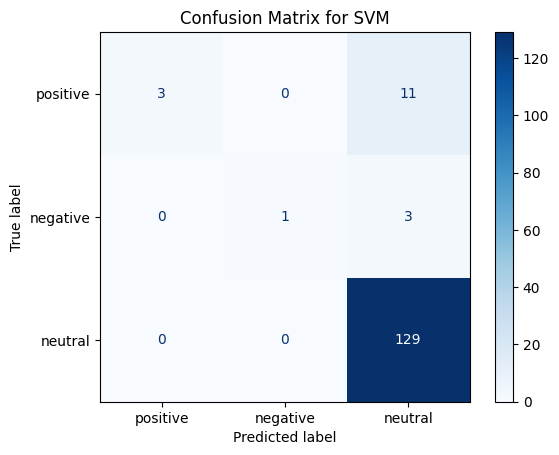

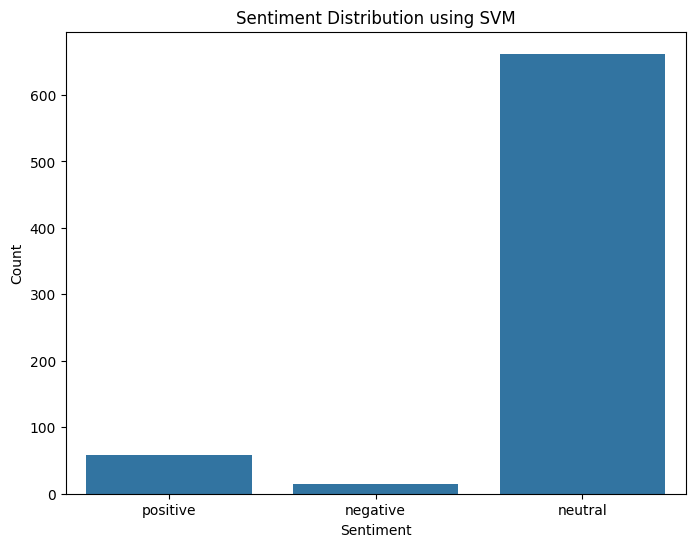

In [78]:
# Visualize confusion matrix for the best model
y_pred = grid_search_svm.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['positive', 'negative', 'neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'negative', 'neutral'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVM')
plt.show()

# Additional Visualizations
# Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='textblob_sentiment', data=data, order=['positive', 'negative', 'neutral'])
plt.title('Sentiment Distribution using SVM')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()